---
# ***Predicción de closing prices implementando una arquitectura LSTM en Tensorflow / Keras***
---
<p style="text-align:right"><i>Otoniel Ruiz Morales<br>Junio 2025</i></p>

## Sobre este Notebook
---
Notebook realizado por **Otoniel Ruiz Morales** estudiante de ingenieria fisica en la Division de Ciencias e Ingenierias, Universidad de Guanajuato como parte del curso **Machine Learning** periodo Enero - Junio 2025. Impartido por el profesor Dr. Luis Carlos Padierna García.

- Versión 1.1 del regresor utilizado para el proyecto "***Deep Reinforcement Learning for Asset Allocation under Stochastic Market Dynamics***"

- **Resumen:**

El *forecasting* o predicción de series de tiempo es un área de investigación activa desde hace décadas, impulsada por la necesidad de anticipar valores futuros en campos como la economía, la ingeniería y las ciencias.

A partir de los años 80/90 las redes neuronales comenzaron a utilizarse en dicha area, dada su capacidad de modelar relaciones tanto lineales como no lineales sin requerir un conocimiento previo exhaustivo del fenómeno a modelar.

Las redes ***Long-Short Term Memory (LSTM)*** son una iteración de las arquitecturas *Recurrent Neural Network (RNN)* diseñadas y optimizadas para la tarea en cuestión.
Representan una solución al problema del *vanishing gradient* presente en la etapa de entrenamiento de las redes recurrentes, dónde los gradientes utilizados para actualizar los pesos se tornan extremadamente pequeños o "*desaparecen*".

Como mencionamos anteriormente algunas de sus principales aplicaciones se encuentran dentro de la economia, en una rama conocida como *econometría*.

En nuestro caso utilizamos una configuración ***Vector-Ouput Stacked LSTM***  para predecir el valor de "*Closing Price*" de una colección de acciones en distintas ventanas temporales.

- **Índice**

1. Extracción de las series temporales

2. Preprocesamiento

3. Configuración de las ventanas de tiempo

4. Configuración del modelo

5. Resultados


In [38]:
import IPython
from sys import version
import os

import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

import tensorflow as tf
import sklearn as skl
import scipy as spy

print (' Condiciones de reproductibilidad '.center(85,'-'))
print ('Python version:       ' + version)
print ('IPython version:      ' + IPython.__version__)
print ('Numpy version:        ' + np.__version__)
print ('Yfinance version:     ' + yf.__version__)
print ('Pandas version:       ' + pd.__version__)
print ('Tensorflow version:   ' + tf.__version__)
print ('Sklearn version:      ' + skl.__version__)
print ('Scipy version:        ' + spy.__version__)
print ('-'*85)

-------------------------- Condiciones de reproductibilidad -------------------------
Python version:       3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
IPython version:      7.34.0
Numpy version:        2.0.2
Yfinance version:     0.2.61
Pandas version:       2.2.2
Tensorflow version:   2.18.0
Sklearn version:      1.6.1
Scipy version:        1.15.3
-------------------------------------------------------------------------------------


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr

In [40]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

## 1. Extracción de las series temporales

A traves de la libreria yFinance extraemos los valores historicos diarios de 10 acciones pertencientes al *National Association of Securities Dealers Automated Quotations (NASDAQ)* del primero de Enero de 2005 al primero de Enero de 2025

Los valores de cada acción quedan guardados como un *dataframe* de pandas y este es agregado a la lista *dataFrames*


In [41]:
tickers = ["AAPL", "AMZN", "NFLX", "MSFT", "NVDA",
           "EBAY", "CSCO", "INTC", "SIRI","ILMN"]
dataFrames = []

for ticker in tickers:
    data = yf.download(tickers=ticker, start="2005-01-01", end="2025-01-01")
    df = pd.DataFrame(data)
    dataFrames.append(df)
print(f"\n\nAlgunos valores de AAPL: \n{dataFrames[0].head(10)}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Algunos valores de AAPL: 
Price          Close      High       Low      Open      Volume
Ticker          AAPL      AAPL      AAPL      AAPL        AAPL
Date                                                          
2005-01-03  0.951065  0.978414  0.940696  0.973455   691992000
2005-01-04  0.960833  0.983824  0.946256  0.958578  1096810400
2005-01-05  0.969248  0.980518  0.962485  0.968646   680433600
2005-01-06  0.969999  0.975408  0.951666  0.971802   705555200
2005-01-07  1.040626  1.046336  0.973004  0.976761  2227450400
2005-01-10  1.036268  1.062415  1.020039  1.049341  1725309600
2005-01-11  0.970149  1.039123  0.963838  1.025599  2611627200
2005-01-12  0.983674  0.990286  0.951215  0.983523  1919702400
2005-01-13  1.048892  1.118317  1.047840  1.107647  3164716800
2005-01-14  1.054902  1.077743  1.039725  1.055653  1770742400


## 2. Preprocesamiento

Primeramente indicamos una normalización a la columna *Close* en un rango de -1 a 1 para acotar los valores extremos

In [42]:
scaler = MinMaxScaler(feature_range=(-1, 1))

Agregaremos tres columnas a cada dataframe correspondientes a las tres medias móviles más usadas en el análisis técnico:

1. **Media Móvil Simple (SMA)**

Corresponde al promedio aritmético de un número fijo de puntos consecutivos, es útil para suavizar curvas con exceso de fluctuaciones o ruido, y para corroborar tendencias.
$$\text{SMA}_t = \frac{1}{k} \sum_{i = t - k + 1}^{t} x_i$$
- $k$: Tamaño de la ventana (número de datos sobre los que se promedia)
- $x_i$: Valores contenidos en la ventana

2. **Media Móvil Ponderada (WMA)**

Variante de la media móvil simple en la que se asignan pesos diferentes a los valores dependiendo su antiguedad, de modo que los datos más nuevos tienen mayor influencia en el promedio que los más viejos.

$$\text{WMA}_t = \frac{\sum_{i=0}^{k-1} w_i \cdot x_{t - i}}{\sum_{i=0}^{k-1} w_i}$$

- $x_{t - i}$: Valor de la serie temporal en el tiempo $t - i$.
- $w_i$: Peso asignado al dato $x_{t - i}$, con $w_0$ siendo el peso más reciente.
- $k$: Tamaño de la ventana.


3. **Media Móvil Exponencial (EMA)**

Variante de la media móvil ponderada, no requiere de una ventana fija para calcularse, enfatisa los datos mas recientes y genera una curva mas suave y menos ruidosa que su antecesora

$$\text{EMA}_t = \alpha \cdot x_t + (1 - \alpha) \cdot \text{EMA}_{t - 1}$$

- $\alpha$: Factor de suavizado, $0 < \alpha < 1$, que controla el "peso" de los datos más recientes.
- $\text{EMA}_{t-1}$: EMA del periodo anterior.


In [43]:
WMA_weights = np.linspace(0.1, 1, 1000)
WMA_window  = 1000
WMA_sum_weigths = np.sum(WMA_weights)



Algunos valores de AAPL despues del preprocesamiento: 
Price          Close      High       Low      Open      Volume WMA SMA EMA
Ticker          AAPL      AAPL      AAPL      AAPL        AAPL            
Date                                                                      
2005-01-03 -1.000000  0.978414  0.940696  0.973455   691992000 NaN NaN NaN
2005-01-04 -0.999924  0.983824  0.946256  0.958578  1096810400 NaN NaN NaN
2005-01-05 -0.999859  0.980518  0.962485  0.968646   680433600 NaN NaN NaN
2005-01-06 -0.999853  0.975408  0.951666  0.971802   705555200 NaN NaN NaN
2005-01-07 -0.999304  1.046336  0.973004  0.976761  2227450400 NaN NaN NaN
2005-01-10 -0.999338  1.062415  1.020039  1.049341  1725309600 NaN NaN NaN
2005-01-11 -0.999852  1.039123  0.963838  1.025599  2611627200 NaN NaN NaN
2005-01-12 -0.999747  0.990286  0.951215  0.983523  1919702400 NaN NaN NaN
2005-01-13 -0.999240  1.118317  1.047840  1.107647  3164716800 NaN NaN NaN
2005-01-14 -0.999193  1.077743  1.039725  1

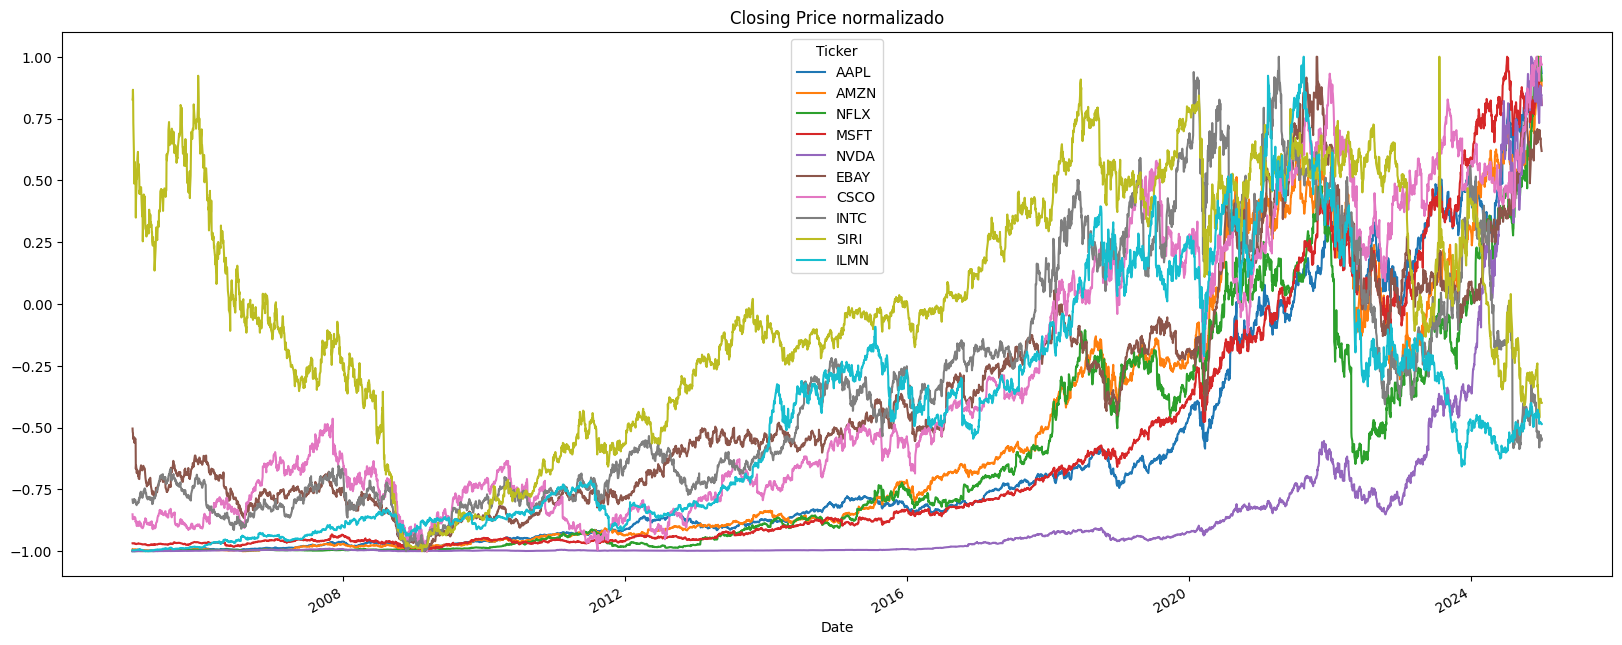

In [59]:
for df in dataFrames:
    df["Close"] = scaler.fit_transform(df[["Close"]])
    df["WMA"] = (df["Close"].rolling(window=WMA_window, center=True)
                            .apply(lambda x: np.sum(WMA_weights * x) / WMA_sum_weigths))
    df["SMA"] = df["Close"].rolling(window=WMA_window).mean()
    df["EMA"] = df["Close"].ewm(span=WMA_window).mean()


print(f"\n\nAlgunos valores de AAPL despues del preprocesamiento: \n{dataFrames[0].head(10)}")

#Graficamos los closing price
fig, ax = plt.subplots(figsize=(20,8))
for dataframe,ticker in zip(dataFrames,tickers):
    dataframe["Close"].plot(ax=ax, label=f"{ticker}")
plt.title("Closing Price normalizado")
plt.show()

## 3. Configuración de las ventanas de tiempo

La predicción se realiza alimentando al modelo con un intervalo determinado de valores y en base a ellos devolver una aproximación de aquellos que les suceden en la serie de tiempo.

Para ello se definen distintos puntos de referencia a lo largo de la serie a partir de los cuales se cuentan los intervalos usados para entrenamiento (en base a los cuales se hará la predicción) y prueba (los que se predecirán).

Cada dataframe contiene un total de 5033 valores de closing price, por lo que se utilizaran los siguientes pasos de referencia y ventanas.

In [45]:
time_steps  = [0, 1000, 2000, 2800]

#Configuraciones ventana entrada/salida: (n_steps_in, n_steps_out)
window_configs = [
    (1000, 100),
    (100, 10),
    (10, 2)
]

#Numero de caracteristicas que predeciremos (en nuestro caso 1: Closing Price)
n_features = 1

Cada ventana se compone de dos valores: n_steps_in y n_steps_out, el primero indica la cantidad de valores que utilizaremos para realizar cada predicción y el segundo la cantidad de valores que predeciremos a partir de los anteriores

**Ejemplo:**

time_step   = 0 |
n_steps_in  = 1000 |
n_steps_out = 100


A partir del valor con **índice 0** se usarán los siguientes 1000 (**[0:999]**) para predecir los 100 posteriores a estos (**[1000:1100]**)

## 4. Configuración del modelo

El modelo propuesto corresponde a una ***Vector-Ouput Stacked LSTM***, cuyo nombre se puede diseccionar en las siguientes partes:

***Vector-Output*** hace referencia a que la red devolverá un vector de predicciones en lugar de un único valor.

***Stacked*** denota que se trata de una arquitectura con múltiples capas de neuronas LSTM, las cuales fungen como la "memoria" del modelo.

En nuestro caso particular contamos con **dos** capas ocultas compuestas de **100** neuronas LSTM cada una, unidas a una ***Fully Conected Layer*** que devuelve el vector de predicciones

In [46]:
# model = Sequential()
# model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps_in, 1)))
# model.add(LSTM(100, activation='tanh'))
# model.add(Dense(n_steps_out, activation='tanh'))
# model.compile(optimizer='adam', loss='mse')

Como función de activación utilizamos la tangente hiperbólica dado que devuelve valores entre -1 y 1, manteniendo paridad con la normalización usada.
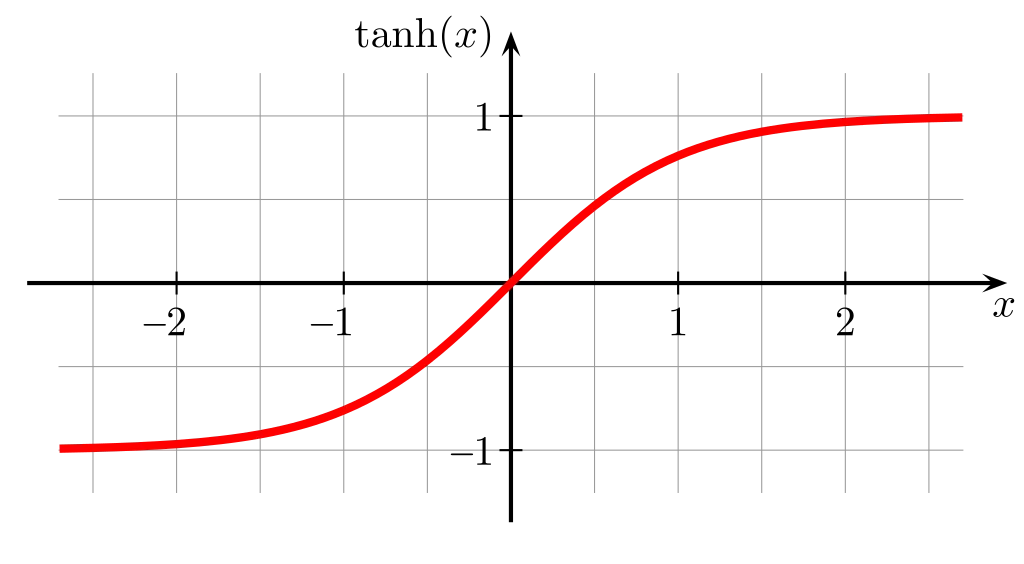

La función de perdida considerada corresponde al *Mean Squared Error*, la más utilizada en regresiones, mide el promedio de los errores al cuadrado, es decir, la diferencia entre la predicción y el valor real que buscamos:

Si ${\displaystyle {\hat {Y}}}$ es un vector de n predicciones y
${\displaystyle Y}$ es el vector de valores reales, entonces el (estimado) error cuadrático medio del predictor es:
$${\displaystyle \operatorname {ECM} ={\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}}$$

el objetivo de la red es minimizar dicha función.

## 5. Resultados

Realizaremos dos predicciones por cada ventana indicada anteriormente, una utilizando los valores usados en el entrenamiento y otra en base a datos separados correspondientes al testeo para comparar los ajustes

El siguiente script muestra los intervalos que el modelo utilizara dependiendo de los parámetros time_step, n_steps_in y n_steps_out


In [47]:
for n_steps_in, n_steps_out in window_configs:
  for time_step in time_steps:
    start_test = time_step + n_steps_in + n_steps_out
    end_test = start_test + n_steps_in
    print(f"Time step = {time_step} - Ventana = {(n_steps_in, n_steps_out)}")
    print(f"Rango de X_train: {time_step} -> {time_step + n_steps_in - 1}")
    print(f"Rango de y_train: {time_step + n_steps_in} -> {time_step + n_steps_in + n_steps_out - 1}")
    print(f"Rango de X_test: {start_test} -> {end_test - 1}")
    print(f"Rango de y_test: {end_test} -> {end_test + n_steps_out}")
    print()


Time step = 0 - Ventana = (1000, 100)
Rango de X_train: 0 -> 999
Rango de y_train: 1000 -> 1099
Rango de X_test: 1100 -> 2099
Rango de y_test: 2100 -> 2200

Time step = 1000 - Ventana = (1000, 100)
Rango de X_train: 1000 -> 1999
Rango de y_train: 2000 -> 2099
Rango de X_test: 2100 -> 3099
Rango de y_test: 3100 -> 3200

Time step = 2000 - Ventana = (1000, 100)
Rango de X_train: 2000 -> 2999
Rango de y_train: 3000 -> 3099
Rango de X_test: 3100 -> 4099
Rango de y_test: 4100 -> 4200

Time step = 2800 - Ventana = (1000, 100)
Rango de X_train: 2800 -> 3799
Rango de y_train: 3800 -> 3899
Rango de X_test: 3900 -> 4899
Rango de y_test: 4900 -> 5000

Time step = 0 - Ventana = (100, 10)
Rango de X_train: 0 -> 99
Rango de y_train: 100 -> 109
Rango de X_test: 110 -> 209
Rango de y_test: 210 -> 220

Time step = 1000 - Ventana = (100, 10)
Rango de X_train: 1000 -> 1099
Rango de y_train: 1100 -> 1109
Rango de X_test: 1110 -> 1209
Rango de y_test: 1210 -> 1220

Time step = 2000 - Ventana = (100, 10)
Ra

En cada imagen se mostrarán dos graficas: las predicciones tanto de y_train como de y_test junto a los valores reales correspondientes.

Se consideraron 3 métricas para cuantificar el desempeño del modelo:
1. **Raíz del error cuadrático medio (RSME)**

Métrica de *precisión* que mide la diferencia entre los valores predichos por un modelo y los valores reales, **siempre es positiva** y entre más cercano sea
al cero, mejor es el ajuste

Viene dado por la ecuacion:
$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

- $y_i$ es el valor real.
- $\hat{y}_i$ es el valor predicho por el modelo.
- $n$ es el número total de observaciones.

2. **Coeficiente de determinación ($R^{2}$)**

Coeficiente que determina la calidad del modelo para replicar los resultados, mide la proporción de la variabilidad de la variable dependiente que es explicada por el modelo:

$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

- $R^2 = 1$: Explica toda la variabilidad de los datos observados. La predicción es perfecta.
- $R^2 = 0$: No explica ninguna variabilidad de los datos. Su desempeño es  como predecir la media de los valores reales.
- $R^2 < 0$: El modelo es peor que una predicción basada en la media.

Cuanto más cercano a 1 sea el valor de $R^2$, mejor será el ajuste.


3. **Coeficiente de correlación de Spearman (SCC)**
El coeficiente de Spearman $r_s$ mide la fuerza y la dirección de una relación monótona entre dos variables. Su valor está en el rango de $-1$ a $1$, y viene dado por:

$$r_s = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}$$
- $d_i$ = $\text{rango}(x_i)$ - $\text{rango}(y_i)$
- $n$: número de observaciones

Se interpreta de la siguiente forma:

- $r_s = 1$: Correlación monótona positiva perfecta. A medida que una variable aumenta, la otra también lo hace de manera consistente.
- $r_s = -1$: Correlación monótona negativa perfecta. A medida que una variable aumenta, la otra disminuye de manera consistente.
- $r_s = 0$: No hay correlación monótona.

En el siguiente bloque se debe agregar el path a la carpeta dónde se guardarán las imágenes

In [61]:
#Ruta de la carpeta
folder_path = '/content/drive/MyDrive/Prueba 10'

#Crear la carpeta si no existe
os.makedirs(folder_path, exist_ok=True)

In [ ]:
for df,ticker in zip(dataFrames,tickers):
    for n_steps_in, n_steps_out in window_configs:
        for time_step in time_steps:
            #Aseguramos que contamos con suficientes datos para particionar
            if time_step + n_steps_in + n_steps_out > len(df):
                continue

            #Extraemos la secuencia de entrenamiento correspondiente a la ventana actual
            seq = df['Close'].iloc[time_step : time_step + n_steps_in + n_steps_out].values

            #Guardamos las fechas inicales y finales que acotan los intervalos
            #utilizados para las predicciones
            date_i_train = df.index[time_step + n_steps_in - 1].strftime('%d-%m-%Y')
            date_f_train = df.index[time_step + n_steps_in + n_steps_out - 1].strftime('%d-%m-%Y')

            date_i_test = df.index[n_steps_in + time_step + n_steps_in - 1].strftime('%d-%m-%Y')
            date_f_test = df.index[n_steps_in + time_step + n_steps_in + n_steps_out - 1].strftime('%d-%m-%Y')

            #Particionamos la secuencia utilizando la funcion split_sequence
            #que devuelve dos listas que contienen las secuencias de prueba con
            #las que se realizara el entrenamiento
            X, y = split_sequence(seq, n_steps_in, n_steps_out)
            X = X.reshape((X.shape[0], X.shape[1], n_features))

            #Creamos un modelo nuevo para cada configuración para evitar
            #leaking y obtener pesos nuevos
            model = Sequential()
            model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
            model.add(LSTM(100, activation='tanh'))
            model.add(Dense(n_steps_out))
            model.compile(optimizer='adam', loss='mse')

            #Entrenamos
            history = model.fit(X, y, epochs=100, verbose=1, validation_split=0)

            #Preparamos la particion de prueba
            start_test = time_step + n_steps_in + n_steps_out
            end_test = start_test + n_steps_in
            if end_test > len(df):
                continue

            X_input = df['Close'].iloc[start_test : end_test].values
            X_input = X_input.reshape((1, n_steps_in, n_features))

            yhat = model.predict(X_input, verbose=1)
            y_real = df['Close'].iloc[end_test : end_test + n_steps_out].values

            #Metricas para la prueba
            r2_test = r2_score(y_real, yhat.flatten())
            spearmanr_test, _ = spearmanr(y_real, yhat.flatten())
            rmse_test = np.sqrt(mean_squared_error(y_real, yhat.flatten()))
            var = np.var(yhat.flatten())


            plt.figure(figsize=(10, 6))
            plt.plot(y_real, label='Real')
            plt.plot(yhat.flatten(), label='Prediccion')
            plt.title(f'{ticker} in: {n_steps_in} out: {n_steps_out} Train: {date_i_train} -> {date_f_train} Test: {date_i_test} -> {date_f_test}')
            plt.xlabel('Tiempo (Dias)')
            plt.ylabel('Precio normalizado (USD)')
            plt.plot(0, label=f'RMSE: {rmse_train:.4f}', linestyle="")
            plt.plot(0, label=f'R²: {r2_train:.4f}', linestyle="")
            plt.plot(0, label=f'Spearman: {spearmanr_test:.4f}', linestyle="")
            plt.plot(0, label=f'Varianza: {var:.4f}', linestyle="")
            plt.legend()

            plt.tight_layout()
            file_name = f"{ticker}_In{n_steps_in}_Out{n_steps_out}_t{time_step}.png"
            file_path = os.path.join(folder_path, file_name)

            #Guardamos la grafica en la carpeta indicada
            plt.savefig(file_path)
            plt.show()